<a href="https://colab.research.google.com/github/atstuyuki/ScikitLearn/blob/main/ARCR_retear_20220303_AdaBoost_SMOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#ライブラリのインポート

# data analysis and wranglinimport seaborn as sns

import math
import pandas as pd
import numpy as np
import random as rnd
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler #正規化（最小0,最大1となるように変換）
from sklearn.preprocessing import StandardScaler #標準化（平均0,分散1となるように変換）
from sklearn.preprocessing import RobustScaler #中央値0,四分位範囲1となるように変換(外れ値の影響を抑える)
from sklearn.preprocessing import LabelEncoder #カテゴリ変数の置換
from sklearn.pipeline import Pipeline #パイプライン（変換器と推定器を結合）
from sklearn.model_selection import train_test_split
#splitting data : train_data 80%,test_data 20%
#X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.20, random_state=1)

# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LinearRegression #線形回帰
from sklearn.linear_model import Lasso, LassoCV #Lasso ,LassoCV(内部チューニング)
from sklearn.linear_model import Ridge, RidgeCV #Ridge ,RidgeCV(内部チューニング) 
from sklearn.linear_model import ElasticNet ,ElasticNetCV #RElasticNet , ElasticNetCV(内部チューニング) 
from sklearn.linear_model import LogisticRegression #ロジスティック回帰
from sklearn.kernel_ridge import KernelRidge #カーネルリッジ回帰
from sklearn.svm import SVC, LinearSVC #SVM
from sklearn.decomposition import PCA #PCA(主成分分析）
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA #LDA(線形判別分析)
from sklearn.ensemble import RandomForestClassifier #ランダムフォレスト
from sklearn.ensemble import RandomForestRegressor #ランダムフォレスト回帰
from sklearn.ensemble import GradientBoostingRegressor #勾配ブースティング回帰
from sklearn.neighbors import KNeighborsClassifier #k近傍法
from sklearn.cluster import KMeans #k-means法 (非階層的クラスタリング(クラスター分析))
from sklearn.cluster import AgglomerativeClustering #階層的クラスタリング(クラスター分析)
from sklearn.cluster import DBSCAN #DBSCAN(クラスター分析)
from sklearn.naive_bayes import GaussianNB #ナイーブベイズ（正規分布ver)
from sklearn.linear_model import Perceptron #パーセプトロン
from sklearn.linear_model import SGDClassifier #確率的勾配降下
from sklearn.tree import DecisionTreeClassifier #決定木
from sklearn.tree import DecisionTreeRegressor #決定木回帰
import xgboost as xgb #XGBoost
import lightgbm as lgb #LightGBM


#model_evaluation & tuning
from sklearn.metrics import r2_score #決定係数R^2
from sklearn.metrics import mean_squared_error #平均二乗誤差MSE 
from sklearn.metrics import confusion_matrix #混同行列
from sklearn.metrics import accuracy_score #正解率
from sklearn.model_selection import KFold #k分割交差検証
from sklearn.model_selection import StratifiedKFold #層化k分割交差検証
from sklearn.model_selection import cross_val_score #交差検証のスコア
from sklearn.model_selection import learning_curve #学習曲線
from sklearn.model_selection import validation_curve #検証曲線
from sklearn.model_selection import GridSearchCV #グリッドサーチ

#ignore warnings which are not unrelated to work
#実行に影響がない警告の非表示
import warnings
warnings.filterwarnings('ignore')

In [2]:
#手元のデータをgoogle colabにupload

from google.colab import files
import os
uploaded = files.upload()
#uploadedは辞書型なのでファイル名を取り出し、絶対パスを取得してfullpathという変数を当てる
for k in uploaded.keys():
  print('file name:',k)
fullpath=os.path.abspath(k)
print('fullpath:',fullpath)

Saving ARCR_retear_20220304.csv to ARCR_retear_20220304.csv
file name: ARCR_retear_20220304.csv
fullpath: /content/ARCR_retear_20220304.csv


In [3]:
#dataのインポート  \を　/に置き換えfullpathを代入　csvを’,'で区切る 
#文字認識異常が出た時は　encoding='UTF-8'や’shift_jis'にする　もともとのCSVファイルの文字形式を確認する
#もともとのCSVで数値がintやfloatではなくstring等の事があるので、良くチェックしておく
#https://insilico-notebook.com/python-unicodedecodeerror/
df=pd.read_csv(fullpath,sep=',',encoding='UTF-8')

In [4]:
df.head()#データの最初の5行の表示

,stump type,Gender,Age,DM,Hyperlipidemia,Tear_size,Goutallier,Retear
0,1,F,68,0,0,1,1,0
1,1,F,71,0,0,1,1,0
2,1,F,59,0,0,1,1,0
3,1,F,59,0,0,1,1,0
4,1,M,72,0,0,1,1,0


In [5]:
#dfの型の確認　object型等は変更する必要がある
df.dtypes

stump type         int64
Gender            object
Age                int64
DM                 int64
Hyperlipidemia     int64
Tear_size          int64
Goutallier         int64
Retear             int64
dtype: object

In [6]:
#今回の解析に不要な列をdrop
#df=df.drop(['Unnamed: 8','Unnamed: 9','Unnamed: 10','Unnamed: 11','Unnamed: 12','Unnamed: 13'],axis='columns') 

In [7]:
#カテゴリ変数をone hot enchoding (drop_first=Trueならダミーエンコーディングなので1次元削減)
#今回はSEX_Mがone hot enchodingされる
df= pd.get_dummies(df,drop_first=True) 
df.dtypes

stump type        int64
Age               int64
DM                int64
Hyperlipidemia    int64
Tear_size         int64
Goutallier        int64
Retear            int64
Gender_M          uint8
dtype: object

In [8]:
#dfの欠損値の確認
df.isnull().sum()

stump type        0
Age               0
DM                0
Hyperlipidemia    0
Tear_size         0
Goutallier        0
Retear            0
Gender_M          0
dtype: int64

In [9]:
# データフレームの統計量記述
df.describe()

,stump type,Age,DM,Hyperlipidemia,Tear_size,Goutallier,Retear,Gender_M
count,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
mean,1.834758,63.603989,0.213675,0.236467,1.908832,1.754986,0.131054,0.618234
std,0.804303,9.028519,0.410485,0.425519,0.805486,0.895909,0.337941,0.486513
min,1.000000,38.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,58.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,2.000000,65.000000,0.000000,0.000000,2.000000,2.000000,0.000000,1.000000
75%,3.000000,70.000000,0.000000,0.000000,2.000000,2.000000,0.000000,1.000000
max,3.000000,83.000000,1.000000,1.000000,4.000000,4.000000,1.000000,1.000000


In [10]:
#dataframeの全体的な情報
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   stump type      351 non-null    int64
 1   Age             351 non-null    int64
 2   DM              351 non-null    int64
 3   Hyperlipidemia  351 non-null    int64
 4   Tear_size       351 non-null    int64
 5   Goutallier      351 non-null    int64
 6   Retear          351 non-null    int64
 7   Gender_M        351 non-null    uint8
dtypes: int64(7), uint8(1)
memory usage: 19.7 KB


In [11]:
df.columns

Index(['stump type', 'Age', 'DM', 'Hyperlipidemia', 'Tear_size', 'Goutallier',
       'Retear', 'Gender_M'],
      dtype='object')

In [12]:
#dataframeの列の並べ替え 目的変数であるRetearを最後の列に入れ替える
new_columns=['stump type', 'Age', 'DM', 'Hyperlipidemia', 'Tear_size', 'Goutallier',
       'Gender_M','Retear']
df=df[new_columns]

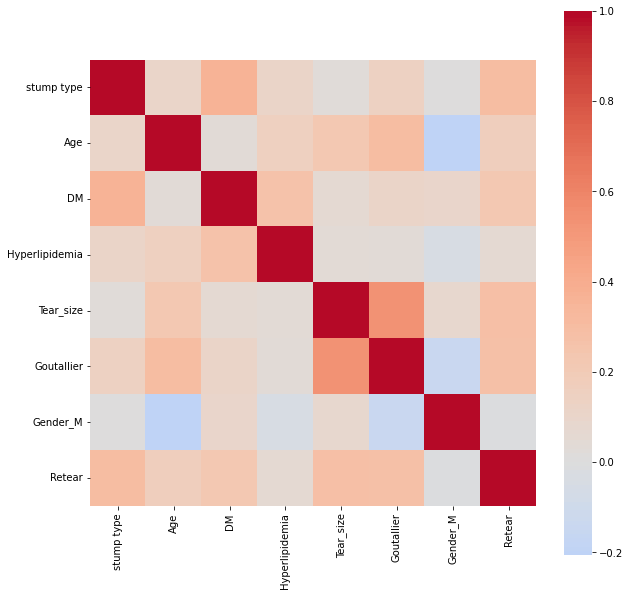

In [13]:
#dfでの相関係数のheatmap 白黒表示であればcmap='binary'とする
#赤色が正の相関を示す
plt.figure(figsize=(10,10))
cmap=sns.color_palette('coolwarm',200)
sns.heatmap(df.corr(),square=True,annot=False,cmap=cmap,center=0)

In [14]:
#Pandasで目的変数別に色分けしたヒストグラムを作成する
#関数の指定
#http://own-search-and-study.xyz/2018/02/27/pandas%e3%81%a7%e7%9b%ae%e7%9a%84%e5%a4%89%e6%95%b0%e5%88%a5%e3%81%ab%e8%89%b2%e5%88%86%e3%81%91%e3%81%97%e3%81%9f%e3%83%92%e3%82%b9%e3%83%88%e3%82%b0%e3%83%a9%e3%83%a0%e3%82%92%e4%bd%9c%e6%88%90/
import pandas as pd
 
def targethist(df, target, save=False, kind='hist', **kwards):
     
    columns = df.columns[df.columns != target]
    pdf = df.pivot_table(index=df.index, columns=target)
     
    for column in columns:
         
        ax = pdf.loc[:, column].plot(kind=kind, title=column, **kwards)
         
        if save==True:
            ax.get_figure().savefig(column+".png") 

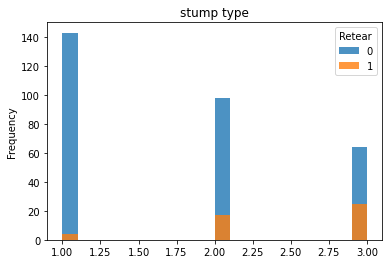

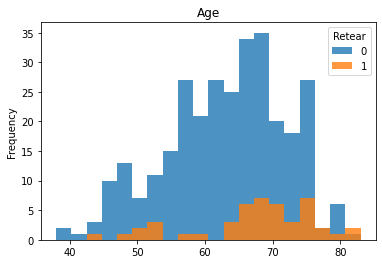

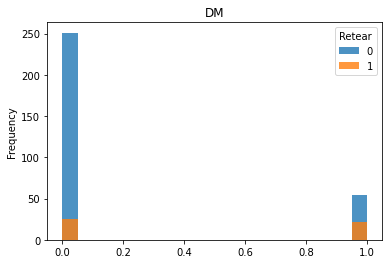

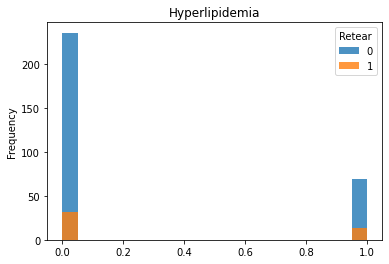

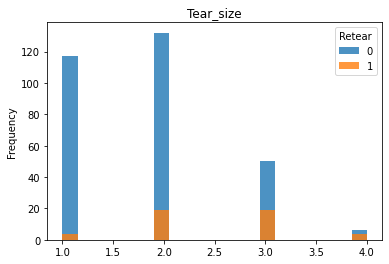

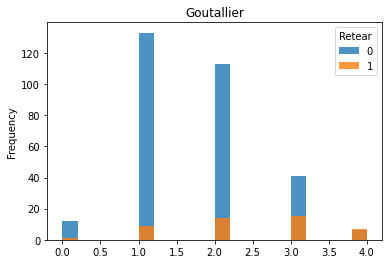

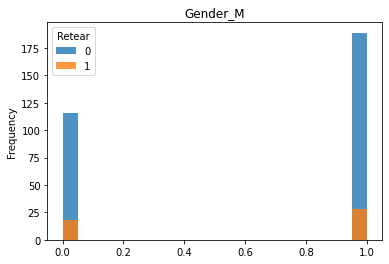

In [15]:
#関数targethistに引数を渡す　
#pandasのplotをラップしている点を活用してパラメータを指定します。
targethist(df,target='Retear', bins=20, alpha=0.8)

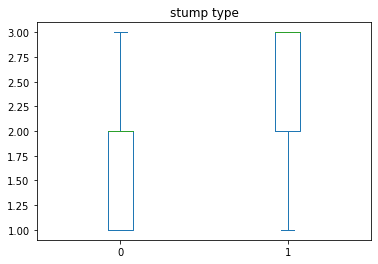

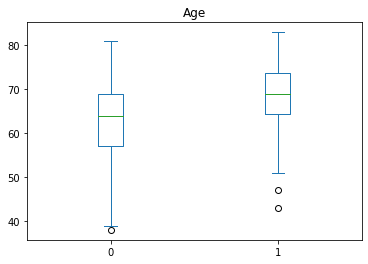

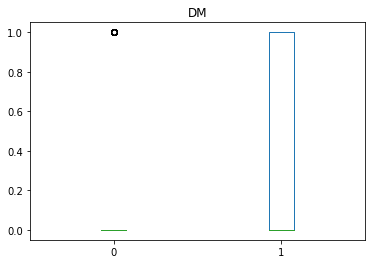

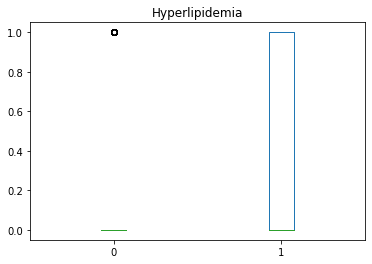

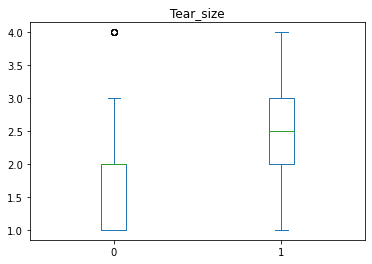

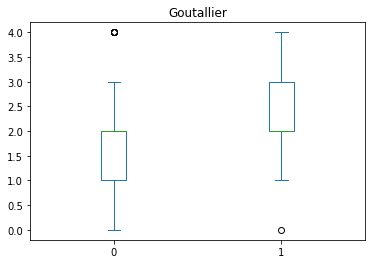

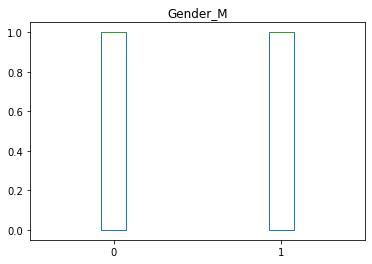

In [16]:
#Retearの有無でのBoxplot
targethist(df, target="Retear", kind='box')

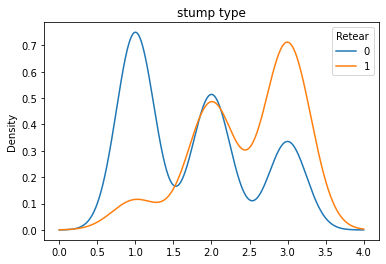

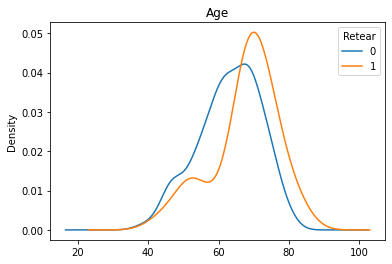

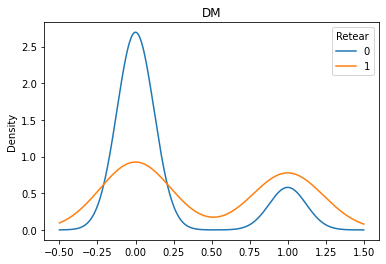

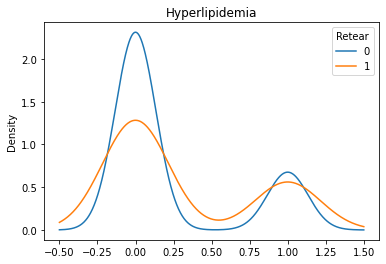

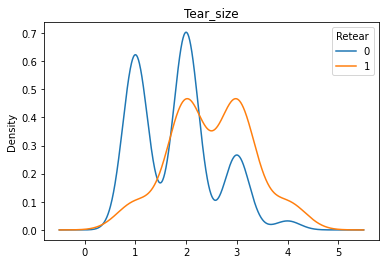

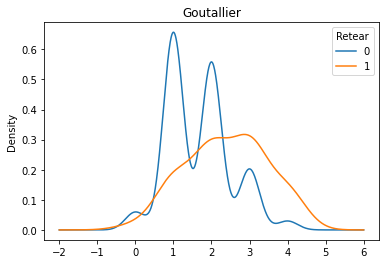

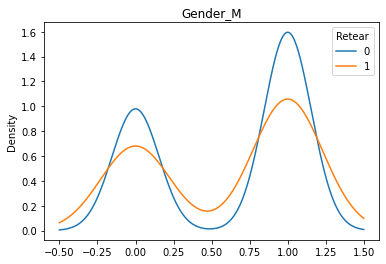

In [17]:
#カーネル密度推定
targethist(df, target="Retear", kind='kde')

In [18]:
#retear (0=No　１＝YES)の有無でグループ分け
grouped=df.groupby('Retear')
#各グループの平均値を表示 省略されないように5データフレームの50列まで表示するように設定
pd.set_option('display.max_columns', 50)
print(grouped.mean())

        stump type        Age        DM  Hyperlipidemia  Tear_size  \
Retear                                                               
0         1.740984  63.016393  0.177049        0.226230   1.819672   
1         2.456522  67.500000  0.456522        0.304348   2.500000   

        Goutallier  Gender_M  
Retear                        
0         1.659016  0.619672  
1         2.391304  0.608696  


In [19]:
#各グル―プの標準偏差を表示
print(grouped.std())

        stump type       Age        DM  Hyperlipidemia  Tear_size  Goutallier  \
Retear                                                                          
0         0.783333  8.860935  0.382338        0.419077   0.771793    0.832201   
1         0.656811  9.258630  0.503610        0.465215   0.781736    1.043035   

        Gender_M  
Retear            
0       0.486265  
1       0.493435  


In [20]:
#statsmodelsによる重回帰分析 結果の解釈は　https://tanuhack.com/statsmodels-multiple-lra/#StatsModels
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# get_dummies()カテゴリ変数をone-hot-enchodingで質的データも対応可能
x = pd.get_dummies(df.drop(['Retear',],axis='columns') ) # ←もちろん増減可能 今回は目的変数以外すべて採用
y = df['Retear']#目的変数の列

# 定数項(y切片)を必要とする線形回帰のモデル式ならば必須
X = sm.add_constant(x)

# 最小二乗法によるモデリング
model = sm.OLS(y,X)
result = model.fit()

# 重回帰分析の結果を表示 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Retear   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     11.80
Date:                Fri, 04 Mar 2022   Prob (F-statistic):           1.76e-13
Time:                        08:45:31   Log-Likelihood:                -78.875
No. Observations:                 351   AIC:                             173.7
Df Residuals:                     343   BIC:                             204.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.4401      0.128     -3.429      0.001      -0.693      -0.188
stump type         0.0960      0.022      4.336      0.000       0.052       0.140
Age                0.0024      0.002      1.207      0.228      -0.001       0.006
DM                 0.1069      0.045      2.391      0.017       0.019       0.195
Hyperlipidemia    -0.0175      0.041     -0.433      0.665      -0.097       0.062
Tear_size          0.0874      0.025      3.524      0.000       0.039       0.136
Goutallier         0.0365      0.023      1.593      0.112      -0.009       0.082
Gender_M          -0.0093      0.036     -0.261      0.794      -0.079       0.061
==============================================================================
Omnibus:                      102.832   Durbin-Watson:                   1.735
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.779
Skew:                           1.591   Prob(JB):                     9.27e-45
Kurtosis:                       4.935   Cond. No.                         508.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# **最初に不均等データの分布を変更せずに、ランダムフォレスト・ロジステック回帰・Adaboost・lightGBMを試す**

In [21]:
#分類するクラスを確認  'Retear'=0が再断裂なし　１が再断裂あり
df['Retear'].value_counts()

0    305
1     46
Name: Retear, dtype: int64

# **データを訓練データと検証データに分割**

In [22]:
target='Retear'

In [23]:
#データセットの分割　正解クラス　説明変数の指定
#訓練データの不要な列を df.drop([],axis='columns')で指定
#テストデータ数が少ないのでtestデータを30%に指定
train_x=df.drop([target],axis='columns') 
train_y=df[target]
(train_x,test_x,train_y,test_y)=train_test_split(train_x,train_y,test_size=0.3,random_state=0)

In [24]:
#データセットの形確認
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(245, 7)
(106, 7)
(245,)
(106,)


In [25]:
# 訓練データ中のRetear=1のサンプル数をカウント(train_yの'1'の数値の合計)
#テストデータ中もカウント
positive_count_train =train_y.sum()
positive_count_test=test_y.sum()
print('positive target numbers in train: {}'.format(positive_count_train))
print('positive target numbers in test:{}'.format(positive_count_test))

positive target numbers in train: 35
positive target numbers in test:11


In [26]:
#評価用関数のインポートおよび定義
from sklearn.metrics import recall_score#recall score用の関数インポート
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [27]:
#感度　特異度の関数定義

#感度
def sensitivity1(test_y, pred_y):
    cm = confusion_matrix(test_y,pred_y, labels=[1, 0])
    return cm[0, 0]/ (cm[0,0]+cm[0,1])

#特異度
def specificity1(test_y, pred_y):
    cm = confusion_matrix(test_y, pred_y, labels=[1, 0])
    return cm[1, 1]/ (cm[1,0]+cm[1,1])

# 不均衡データ　ランダムフォレストモデル＋gridSearchによる予測モデル構築

In [28]:
#ランダムフォレストモデルの構築
gridsearch = {'n_estimators': [100,200,300,400],#決定木の数を辞書で渡す
             'max_depth': [4,5,6]}#決定木の数を辞書で渡す
score='roc_auc'#モデルの評価関数を指定
                 #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                 #　今回は検診で偽陰性をへらしたいのでpercisionを使用
model_rf=GridSearchCV(RandomForestClassifier(),#分類器の指定
                 gridsearch,#グリッドサーチで定義した辞書を渡す
                 cv=5,              #交差検定の回数指定
                 n_jobs= -1, #-1に設定するとコア数で並列実行
                 scoring=score,#モデルの評価関数の指定 今回は異常検知なのでrecall使用
                 verbose=True) #verbose=Trueで実行状況の表示
model_rf.fit(train_x,train_y)#学習の実行 fit関数
pred_y=model_rf.predict(test_x)#予測値の算出
print('不均衡データ　ランダムフォレストモデルの精度')
train_accuracy=model_rf.score(train_x,train_y)#学習データでの精度の算出
print('Train Accuracy:{}'.format(train_accuracy))
test_accuracy=accuracy_score(test_y,pred_y)#テストデータでの精度の算出
print('Test Accuracy:{}'.format(test_accuracy))
recall=recall_score(test_y,pred_y)
print('Recall:{}'.format(recall))
precision=precision_score(test_y,pred_y)
print('Precision:{}'.format(precision))
f_measure=f1_score(test_y,pred_y)
print('F-measure:{}'.format(f_measure))
sensitivity=sensitivity1(test_y,pred_y)
print('Sensitivity:{}'.format(sensitivity))
specificity=specificity1(test_y,pred_y)
print('Specificity:{}'.format(specificity))
#不均衡モデルの評価に感度と特異度の相乗平均g_meanを計算
g_mean=math.sqrt(sensitivity*specificity)
print('G_mean:{}'.format(g_mean))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
不均衡データ　ランダムフォレストモデルの精度
Train Accuracy:0.979591836734694
Test Accuracy:0.9056603773584906
Recall:0.18181818181818182
Precision:0.6666666666666666
F-measure:0.28571428571428575
Sensitivity:0.18181818181818182
Specificity:0.9894736842105263
G_mean:0.4241512775179343


不均衡データ　ランダムフォレストモデルの混合行列


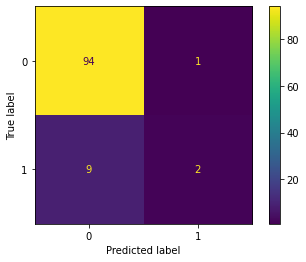

In [29]:
#plot_confusion_matrixのデフォルト設定でもプロットしてみる
#confusion_matrix関数と渡す引数がちがうことに注意
print('不均衡データ　ランダムフォレストモデルの混合行列')
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
plot_confusion_matrix(model_rf,test_x,test_y)

不均衡データ　ランダムフォレストモデルのROC曲線


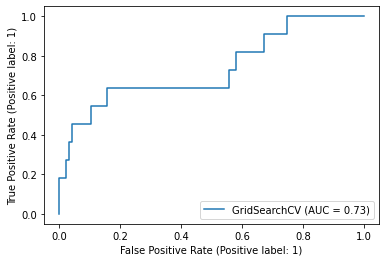

In [30]:
#plot_roc_curve関数によるROC曲線のプロット　引数は　モデル、test_x, test_y
print('不均衡データ　ランダムフォレストモデルのROC曲線')
from sklearn import metrics
rf_disp=metrics.plot_roc_curve(model_rf,test_x,test_y)  # treeのROC曲線
plt.show(rf_disp)  

# **不均衡データロジスティック回帰モデルによる予測モデル構築**

In [31]:
#ロジスティック回帰による分類
from sklearn.model_selection import cross_val_predict #交差検証
model_LR=LogisticRegression(solver='liblinear')#ハイパーパラメーターをかっこ内に記述
pred_y=cross_val_predict(model_LR,test_x,test_y,cv=5) #cross validation の分割数を指定
model_LR.fit(train_x,train_y)

acc=accuracy_score(test_y,pred_y)
recall=recall_score(test_y,pred_y)
precision=precision_score(test_y,pred_y)
print('不均衡データ　ロジスティック回帰モデルの精度')
print('Accuracy:',acc)
print('Recall:',recall)
print('Precision:',precision)
conf_matrix=confusion_matrix(test_y,pred_y)
tn_LR,fp_LR,fn_LR,tp_LR=conf_matrix.ravel()
print('tn_LR,fp_LR,fn_LR,tp_LR=',tn_LR,fp_LR,fn_LR,tp_LR)
f_measure=f1_score(test_y,pred_y)
print('F-measure:{}'.format(f_measure))
sensitivity=sensitivity1(test_y,pred_y)
print('Sensitivity:{}'.format(sensitivity))
specificity=specificity1(test_y,pred_y)
print('Specificity:{}'.format(specificity))
g_mean=math.sqrt(sensitivity*specificity)
print('G_mean:{}'.format(g_mean))

不均衡データ　ロジスティック回帰モデルの精度
Accuracy: 0.8867924528301887
Recall: 0.0
Precision: 0.0
tn_LR,fp_LR,fn_LR,tp_LR= 94 1 11 0
F-measure:0.0
Sensitivity:0.0
Specificity:0.9894736842105263
G_mean:0.0


不均衡データ　ロジスティック回帰モデルの精度


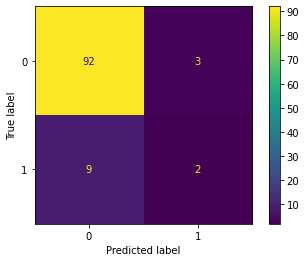

In [32]:
#plot_confusion_matrixのデフォルト設定でプロット
#confusion_matrix関数と渡す引数がちがうことに注意
print('不均衡データ　ロジスティック回帰モデルの精度')
plot_confusion_matrix(model_LR,test_x,test_y)

不均衡pデータ　ロジスティック回帰モデルの精度


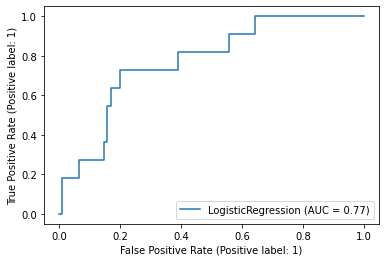

In [33]:
#plot_roc_curve関数によるROC曲線のプロット　引数は　モデル、test_x, 
print('不均衡pデータ　ロジスティック回帰モデルの精度')
LR_disp=metrics.plot_roc_curve(model_LR,test_x,test_y) 
ax = plt.gca()
plt.show()  

# **不均衡データ AdaBoost モデルによる予測モデル構築**

In [34]:
#不均衡データに強いとされるAdaBoostでグリッドサーチしてみる
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
n_estimators = [100,200,300,400];
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)
learning_r = [0.1,1,0.01]

parameters = {'n_estimators':n_estimators,
              'learning_rate':learning_r
              
        }
Ada_Boost_CV = GridSearchCV(AdaBoostClassifier(base_estimator= None, ## If None, then the base estimator is a decision tree.
                                     ),
                                 param_grid=parameters,
                                 cv=cv,
                                 n_jobs = -1)
Ada_Boost_CV.fit(train_x,train_y) 
print('不均衡データ　AdaBoostモデルの精度')
print(Ada_Boost_CV.best_params_)
pred_y=Ada_Boost_CV.predict(test_x)#予測値の算出
train_accuracy=Ada_Boost_CV.score(train_x,train_y)#学習データでの精度の算出
print('Train Accuracy:{}'.format(train_accuracy))
test_accuracy=accuracy_score(test_y,pred_y)#テストデータでの精度の算出
print('Test Accuracy:{}'.format(test_accuracy))
recall=recall_score(test_y,pred_y)
print('Recall:{}'.format(recall))
precision=precision_score(test_y,pred_y)
print('Precision:{}'.format(precision))
f_measure=f1_score(test_y,pred_y)
print('F-measure:{}'.format(f_measure))
sensitivity=sensitivity1(test_y,pred_y)
print('Sensitivity:{}'.format(sensitivity))
specificity=specificity1(test_y,pred_y)
print('Specificity:{}'.format(specificity))
#不均衡モデルの評価に感度と特異度の相乗平均g_meanを計算
g_mean=math.sqrt(sensitivity*specificity)
print('G_mean:{}'.format(g_mean))

不均衡データ　AdaBoostモデルの精度
{'learning_rate': 0.1, 'n_estimators': 200}
Train Accuracy:0.8938775510204081
Test Accuracy:0.9245283018867925
Recall:0.45454545454545453
Precision:0.7142857142857143
F-measure:0.5555555555555556
Sensitivity:0.45454545454545453
Specificity:0.9789473684210527
G_mean:0.6670652715851905


不均衡pデータ　AdaBoost モデルの精度


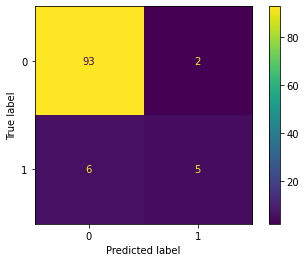

In [35]:
#Ada_Boostモデルの混合行列
#plot_confusion_matrixのデフォルト設定でプロット
#confusion_matrix関数と渡す引数がちがうことに注意
print('不均衡pデータ　AdaBoost モデルの精度')
plot_confusion_matrix(Ada_Boost_CV,test_x,test_y)

不均衡データ　AdaBoost モデルの精度


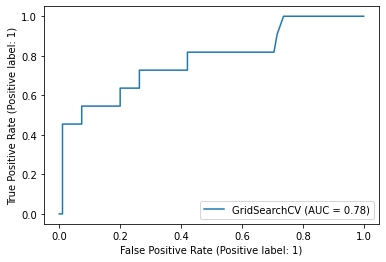

In [36]:
#Ada_BoostのROC曲線
print('不均衡データ　AdaBoost モデルの精度')
Ada_disp=metrics.plot_roc_curve(Ada_Boost_CV,test_x,test_y)  # treeのROC曲線
plt.show(Ada_disp)  

# **不均衡データlight GBM モデルによる予測モデル構築**

In [37]:
#LightGBM scikit learn APIによる訓練 confusion matrix関数を使うにはsk-learn APIが必要

model_lgb = lgb.LGBMClassifier(objective='binary',
                        metric='auc',
                        n_estimators=1000,
                        early_stopping_rounds=100)
model_lgb.fit(train_x,train_y,#scilit learn APIではfitで訓練データを渡す original APIではtrain 
        eval_set=[(test_x, test_y)],
        verbose=50)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.751196
[100]	valid_0's auc: 0.768421
[150]	valid_0's auc: 0.76555
[200]	valid_0's auc: 0.766507
Early stopping, best iteration is:
[128]	valid_0's auc: 0.781818


LGBMClassifier(early_stopping_rounds=100, metric='auc', n_estimators=1000,
               objective='binary')

In [38]:
pred_y=model_lgb.predict(test_x)
acc=accuracy_score(test_y,pred_y)
recall=recall_score(test_y,pred_y)
precision=precision_score(test_y,pred_y)
f_measure=f1_score(test_y,pred_y)
print('Accuracy:',acc)
print('Recall:',recall)
print('Precision:',precision)
print('F-measure:{}'.format(f_measure))
sensitivity=sensitivity1(test_y,pred_y)
print('Sensitivity:{}'.format(sensitivity))
specificity=specificity1(test_y,pred_y)
print('Specificity:{}'.format(specificity))
conf_matrix=confusion_matrix(test_y,pred_y)
tn,fp,fn,tp=conf_matrix.ravel()
print('tn,fp,fn,tp=',tn,fp,fn,tp)
#不均衡モデルの評価に感度と特異度の相乗平均g_meanを計算
g_mean=math.sqrt(sensitivity*specificity)
print('G_mean:{}'.format(g_mean))

Accuracy: 0.8207547169811321
Recall: 0.36363636363636365
Precision: 0.25
F-measure:0.2962962962962963
Sensitivity:0.36363636363636365
Specificity:0.8736842105263158
tn,fp,fn,tp= 83 12 7 4
G_mean:0.5636517979056721


不均衡データ　light GBM モデルの精度


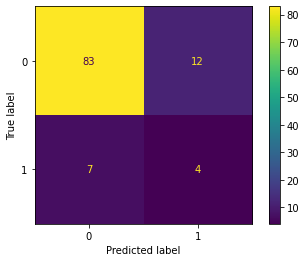

In [39]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
print('不均衡データ　light GBM モデルの精度')
plot_confusion_matrix(model_lgb,test_x,test_y)

不均衡データ　lightGBM モデルの精度


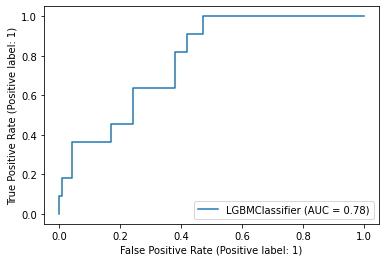

In [40]:
print('不均衡データ　lightGBM モデルの精度')
lgb_disp=metrics.plot_roc_curve(model_lgb,test_x,test_y)  # LGBMClassigier modelのROC曲線
plt.show()   

# **oversamplingを行ってデータの不均衡をなくす


In [41]:
#imbalanced-learnでデータの不均衡に対応
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
print(imblearn.__version__)

0.8.1


 公式ドキュメントでは先にtrain_test_splitしており、testデータではSMOTEしていない kaggleのこの記事参照　 https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets 
 testデータにはoversamplingしたデータは使わない　leakが生じるため
ほかに色々試しているkaggleのnotebook https://www.kaggle.com/andreanuzzo/balance-the-imbalanced-rf-and-xgboost-with-smote

In [42]:
#テストデータの’１’の数のカウント
positive_count_test =test_y.sum()
print('positive count test: {}'.format(positive_count_test))

positive count test: 11


In [43]:
#訓練データのみに対してSMOTEによる水増し
smote = SMOTE(random_state=42)
x_SMOTE, y_SMOTE = smote.fit_resample(train_x,train_y)
print('positive count before oversampling(SMOTE)',train_y.sum())
print('positive count after oversampling(SMOTE)',y_SMOTE.sum())

positive count before oversampling(SMOTE) 35
positive count after oversampling(SMOTE) 210


# **OverSampling dataにたいしてRandom Forestにてモデル作成**

In [44]:
#ランダムフォレストモデルの構築
gridsearch = {'n_estimators': [100,200,300,400],#決定木の数を辞書で渡す
             'max_depth': [4,5,6]}#決定木の数を辞書で渡す
score='balanced_accuracy'#モデルの評価関数を指定https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
smote_model_rf=GridSearchCV(RandomForestClassifier(),#分類器の指定
                 gridsearch,#グリッドサーチで定義した辞書を渡す
                 cv=5,              #交差検定の回数指定
                 n_jobs= -1, #-1に設定するとコア数で並列実行
                 scoring=score,#モデルの評価関数の指定 今回は異常検知なのでrecall使用
                 verbose=True) #verbose=Trueで実行状況の表示
smote_model_rf.fit(x_SMOTE,y_SMOTE)#学習の実行 fit関数
pred_y=smote_model_rf.predict(test_x)#予測値の算出
train_accuracysmote_=model_rf.score(x_SMOTE,y_SMOTE)#学習データでの精度の算出
print('Oversamplingデータ　ランダムフォレスト モデルの精度')
print('Train Accuracy:{}'.format(train_accuracy))
test_accuracy=accuracy_score(test_y,pred_y)#テストデータでの精度の算出
print('Test Accuracy:{}'.format(test_accuracy))
recall=recall_score(test_y,pred_y)
print('Recall:{}'.format(recall))
precision=precision_score(test_y,pred_y)
print('Precision:{}'.format(precision))
f_measure=f1_score(test_y,pred_y)
print('F-measure:{}'.format(f_measure))
sensitivity=sensitivity1(test_y,pred_y)
print('Sensitivity:{}'.format(sensitivity))
specificity=specificity1(test_y,pred_y)
print('Specificity:{}'.format(specificity))
#不均衡モデルの評価に感度と特異度の相乗平均g_meanを計算
g_mean=math.sqrt(sensitivity*specificity)
print('G_mean:{}'.format(g_mean))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Oversamplingデータ　ランダムフォレスト モデルの精度
Train Accuracy:0.8938775510204081
Test Accuracy:0.8301886792452831
Recall:0.45454545454545453
Precision:0.29411764705882354
F-measure:0.35714285714285715
Sensitivity:0.45454545454545453
Specificity:0.8736842105263158
G_mean:0.6301818678785283


In [45]:
smote_model_rf.best_estimator_

RandomForestClassifier(max_depth=6)

Oversamplingデータ　ランダムフォレスト モデルの精度


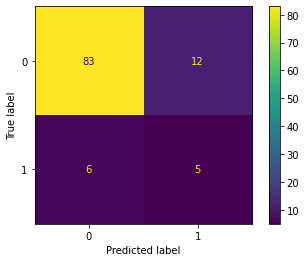

In [46]:
#plot_confusion_matrixのデフォルト設定でプロット
#confusion_matrix関数と渡す引数がちがうことに注意
print('Oversamplingデータ　ランダムフォレスト モデルの精度')
plot_confusion_matrix(smote_model_rf,test_x,test_y)

Oversamplingデータ　ランダムフォレスト モデルの精度


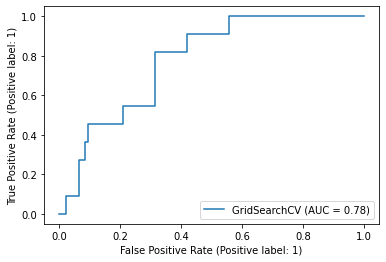

In [49]:
#plot_roc_curve関数によるROC曲線のプロット　引数は　モデル、test_x, test_y
print('Oversamplingデータ　ランダムフォレスト モデルの精度')
from sklearn import metrics
smote_rf_disp=metrics.plot_roc_curve(smote_model_rf,test_x,test_y)  # treeのROC曲線
plt.show(smote_rf_disp)  

# **OverSampling dataにたいしてロジステック回帰にてモデル作成**

In [50]:
#ロジスティック回帰による分類
from sklearn.model_selection import cross_val_predict #交差検証
smote_model_LR=LogisticRegression(solver='liblinear')#ハイパーパラメーターをかっこ内に記述
pred_y=cross_val_predict(smote_model_LR,test_x,test_y,cv=5) #cross validation の分割数を指定
smote_model_LR.fit(x_SMOTE,y_SMOTE)

acc=accuracy_score(test_y,pred_y)
recall=recall_score(test_y,pred_y)
precision=precision_score(test_y,pred_y)
print('Oversamplingデータ　ロジステック回帰 モデルの精度')
print('Accuracy:',acc)
print('Recall:',recall)
print('Precision:',precision)
conf_matrix=confusion_matrix(test_y,pred_y)
tn_LR,fp_LR,fn_LR,tp_LR=conf_matrix.ravel()
print('tn_LR,fp_LR,fn_LR,tp_LR=',tn_LR,fp_LR,fn_LR,tp_LR)
f_measure=f1_score(test_y,pred_y)
print('F-measure:{}'.format(f_measure))
sensitivity=sensitivity1(test_y,pred_y)
print('Sensitivity:{}'.format(sensitivity))
specificity=specificity1(test_y,pred_y)
print('Specificity:{}'.format(specificity))
#不均衡モデルの評価に感度と特異度の相乗平均g_meanを計算
g_mean=math.sqrt(sensitivity*specificity)
print('G_mean:{}'.format(g_mean))

Oversamplingデータ　ロジステック回帰 モデルの精度
Accuracy: 0.8867924528301887
Recall: 0.0
Precision: 0.0
tn_LR,fp_LR,fn_LR,tp_LR= 94 1 11 0
F-measure:0.0
Sensitivity:0.0
Specificity:0.9894736842105263
G_mean:0.0


Oversamplingデータ　ロジステック回帰 モデルの精度


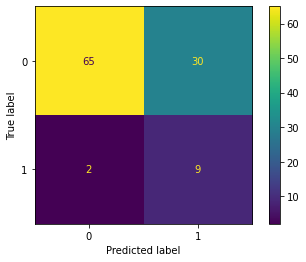

In [51]:
#plot_confusion_matrixのデフォルト設定でプロット
#confusion_matrix関数と渡す引数がちがうことに注意
print('Oversamplingデータ　ロジステック回帰 モデルの精度')
plot_confusion_matrix(smote_model_LR,test_x,test_y)

Oversamplingデータ　ロジステック回帰 モデルの精度


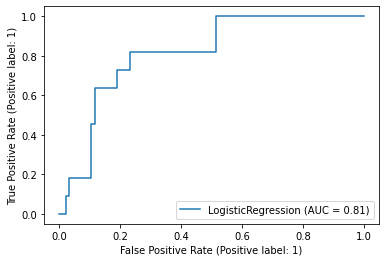

In [52]:
#plot_roc_curve関数によるROC曲線のプロット　引数は　モデル、test_x, test_y
print('Oversamplingデータ　ロジステック回帰 モデルの精度')
smote_LR_disp=metrics.plot_roc_curve(smote_model_LR,test_x,test_y)  
ax = plt.gca()
plt.show()  

# **Oversampling（SMOTE）にたいしてAdaboostでのモデル構築**

In [53]:
#AdaBoostによるSMOTEデータに対する訓練と分類
#AdaBoostでグリッドサーチしてみる
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
n_estimators = [100,200,300,400];
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)
learning_r = [0.1,1,0.01]

parameters = {'n_estimators':n_estimators,
              'learning_rate':learning_r
              
        }
smote_Ada_Boost_CV = GridSearchCV(AdaBoostClassifier(base_estimator= None, ## If None, then the base estimator is a decision tree.
                                     ),
                                 param_grid=parameters,
                                 cv=cv,
                                 n_jobs = -1)
smote_Ada_Boost_CV.fit(x_SMOTE,y_SMOTE) 
print(smote_Ada_Boost_CV.best_params_)
pred_y=smote_Ada_Boost_CV.predict(test_x)#予測値の算出
train_accuracy=smote_Ada_Boost_CV.score(x_SMOTE,y_SMOTE)#学習データでの精度の算出

print('Oversamplingデータ　AdaBoost モデルの精度')
print('Train Accuracy:{}'.format(train_accuracy))
test_accuracy=accuracy_score(test_y,pred_y)#テストデータでの精度の算出
print('Test Accuracy:{}'.format(test_accuracy))
recall=recall_score(test_y,pred_y)
print('Recall:{}'.format(recall))
precision=precision_score(test_y,pred_y)
print('Precision:{}'.format(precision))
f_measure=f1_score(test_y,pred_y)
print('F-measure:{}'.format(f_measure))
sensitivity=sensitivity1(test_y,pred_y)
print('Sensitivity:{}'.format(sensitivity))
specificity=specificity1(test_y,pred_y)
print('Specificity:{}'.format(specificity))
#不均衡モデルの評価に感度と特異度の相乗平均g_meanを計算
g_mean=math.sqrt(sensitivity*specificity)
print('G_mean:{}'.format(g_mean))

{'learning_rate': 0.1, 'n_estimators': 400}
Oversamplingデータ　AdaBoost モデルの精度
Train Accuracy:0.8238095238095238
Test Accuracy:0.7358490566037735
Recall:0.8181818181818182
Precision:0.2571428571428571
F-measure:0.39130434782608686
Sensitivity:0.8181818181818182
Specificity:0.7263157894736842
G_mean:0.7708815558863383


Oversamplingデータ　AdaBoost モデルの精度


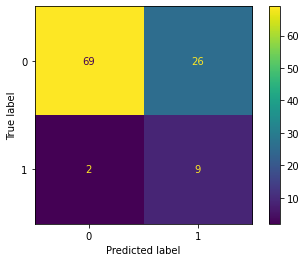

In [54]:
#Ada_Boostモデルの混合行列
#plot_confusion_matrixのデフォルト設定でプロット
#confusion_matrix関数と渡す引数がちがうことに注意
print('Oversamplingデータ　AdaBoost モデルの精度')
plot_confusion_matrix(smote_Ada_Boost_CV,test_x,test_y)

Oversamplingデータ　AdaBoost モデルの精度


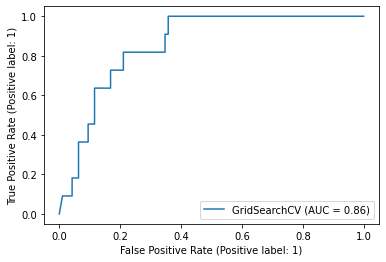

In [55]:
#Ada_BoostのROC曲線
print('Oversamplingデータ　AdaBoost モデルの精度')
smote_Ada_disp=metrics.plot_roc_curve(smote_Ada_Boost_CV,test_x,test_y)  
plt.show(smote_Ada_disp)  

# **Oversampling（SMOTE）に対してのLightGBM のscilit learn　APIによるモデル構築**

In [56]:
#LightGBM scikit learn APIによる訓練 confusion matrix関数を使うにはsk-learn APIが必要

smote_model_lgb = lgb.LGBMClassifier(objective='binary',
                        metric='auc',
                        n_estimators=1000,
                        early_stopping_rounds=100)
smote_model_lgb.fit(x_SMOTE,y_SMOTE,#scilit learn APIではfitで訓練データを渡す original APIではtrain 
        eval_set=[(test_x, test_y)],
        verbose=50)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.776077
[100]	valid_0's auc: 0.781818
[150]	valid_0's auc: 0.755981
Early stopping, best iteration is:
[89]	valid_0's auc: 0.792344


LGBMClassifier(early_stopping_rounds=100, metric='auc', n_estimators=1000,
               objective='binary')

Oversamplingデータ　LightGBM モデルの精度


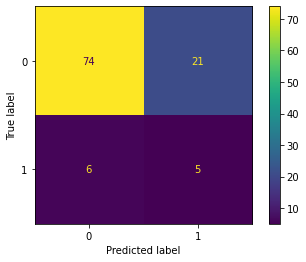

In [57]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
print('Oversamplingデータ　LightGBM モデルの精度')
plot_confusion_matrix(smote_model_lgb,test_x,test_y)

In [58]:
pred_y=smote_model_lgb.predict(test_x)
acc=accuracy_score(test_y,pred_y)
recall=recall_score(test_y,pred_y)
precision=precision_score(test_y,pred_y)
f_measure=f1_score(test_y,pred_y)

print('Oversamplingデータ　LightGBM モデルの精度')
print('Accuracy:',acc)
print('Recall:',recall)
print('Precision:',precision)
print('F-measure:{}'.format(f_measure))
sensitivity=sensitivity1(test_y,pred_y)
print('Sensitivity:{}'.format(sensitivity))
specificity=specificity1(test_y,pred_y)
print('Specificity:{}'.format(specificity))
conf_matrix=confusion_matrix(test_y,pred_y)
tn,fp,fn,tp=conf_matrix.ravel()
print('tn,fp,fn,tp=',tn,fp,fn,tp)
#不均衡モデルの評価に感度と特異度の相乗平均g_meanを計算
g_mean=math.sqrt(sensitivity*specificity)
print('G_mean:{}'.format(g_mean))

Oversamplingデータ　LightGBM モデルの精度
Accuracy: 0.7452830188679245
Recall: 0.45454545454545453
Precision: 0.19230769230769232
F-measure:0.27027027027027023
Sensitivity:0.45454545454545453
Specificity:0.7789473684210526
tn,fp,fn,tp= 74 21 6 5
G_mean:0.5950352810093977


Oversamplingデータ　LightGBM モデルの精度


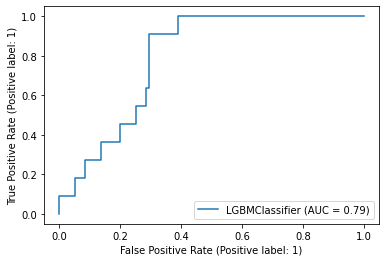

In [59]:
print('Oversamplingデータ　LightGBM モデルの精度')
smote_lgb_disp=metrics.plot_roc_curve(smote_model_lgb,test_x,test_y)  # LGBMClassigier model2のROC曲線
plt.show()   

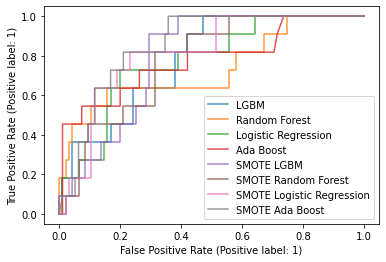

In [60]:
#いままでのROC曲線をまとめて表示
ax = plt.gca()
lgb_disp.plot(ax=ax, alpha=0.8,label='LGBM')
rf_disp.plot(ax=ax,alpha=0.8,label='Random Forest')
LR_disp.plot(ax=ax,alpha=0.8,label='Logistic Regression')
Ada_disp.plot(ax=ax,alpha=0.8,label='Ada Boost')

smote_lgb_disp.plot(ax=ax, alpha=0.8,label='SMOTE LGBM')
smote_rf_disp.plot(ax=ax,alpha=0.8,label='SMOTE Random Forest')
smote_LR_disp.plot(ax=ax,alpha=0.8,label='SMOTE Logistic Regression')
smote_Ada_disp.plot(ax=ax,alpha=0.8,label='SMOTE Ada Boost')

plt.show()